In [2]:
import argparse, gpytorch
import os, sys
from utilstest import pretrain_teacher_student, joint_train_teacher_student
from netmodel import MLPModel
from gp_models import ExactGPModel, GPModel
import torch
from pathlib import Path
from math import log
from gev import GEV
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from botorch.utils.transforms import normalize, unnormalize

# %config InlineBackend.figure_format = 'svg'

torch.Size([200, 2])
torch.Size([200, 2]) torch.Size([200, 1])
Iter 1/100 - Loss: -1249.183   lengthscale: 1.000   noise: 0.002, mu:0.582, var:0.002
Iter 2/100 - Loss: -1273.038   lengthscale: 0.905   noise: 0.002, mu:0.575, var:0.002
Iter 3/100 - Loss: -1297.010   lengthscale: 0.824   noise: 0.001, mu:0.571, var:0.002
Iter 4/100 - Loss: -1319.251   lengthscale: 0.764   noise: 0.001, mu:0.567, var:0.002
Iter 5/100 - Loss: -1337.490   lengthscale: 0.732   noise: 0.001, mu:0.564, var:0.002
Iter 6/100 - Loss: -1351.457   lengthscale: 0.724   noise: 0.001, mu:0.560, var:0.002
Iter 7/100 - Loss: -1362.360   lengthscale: 0.731   noise: 0.001, mu:0.556, var:0.002
Iter 8/100 - Loss: -1371.527   lengthscale: 0.747   noise: 0.001, mu:0.551, var:0.002
Iter 9/100 - Loss: -1380.244   lengthscale: 0.766   noise: 0.001, mu:0.546, var:0.002
Iter 10/100 - Loss: -1389.817   lengthscale: 0.779   noise: 0.001, mu:0.541, var:0.002
Iter 11/100 - Loss: -1401.329   lengthscale: 0.783   noise: 0.001, mu:0.537,

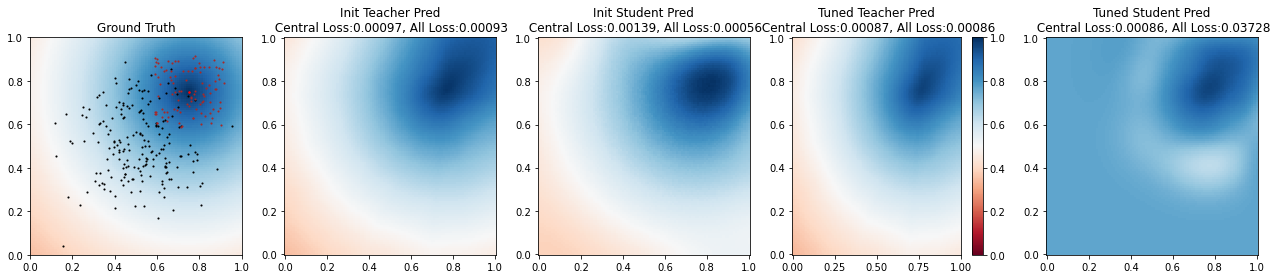

In [27]:
def f(x,x_obj):
    assert torch.is_tensor(x)        
    return torch.exp(-torch.norm(x-x_obj, dim=-1)).view(-1,1)

labelLocList = ['Diag', 'All','Botleft','Gauss']
unlabelLocList = ['GEV','Far','Cen','Topright']
flagLabelLoc = labelLocList[3]
flagUnlabelLoc = unlabelLocList[2]
n = 101
torch.random.manual_seed(0)
plt.show()
device = torch.device(0)
xLabel = torch.tensor([
    [0.5,0.2],
    [0.2,0.5],
    [0.5,0.5],
    [0.4,0.4],
    [0.3, 0.45],
    [0.45,0.3]],dtype=torch.float,device=device)
xLabel = torch.rand(100, 2,dtype=torch.float,device=device)*0.333
xLabelTemp = 1-torch.rand(100, 2,dtype=torch.float,device=device)*0.333
xObj = torch.tensor([0.5,0.5],dtype=torch.float,device=device)
if flagLabelLoc == labelLocList[0]:
    xLabel = torch.cat([xLabel, xLabelTemp], dim=0)
elif flagLabelLoc == labelLocList[1]:
    xLabel = torch.rand(200, 2,dtype=torch.float,device=device)
elif flagLabelLoc == labelLocList[2]:
    xLabel = torch.rand(200, 2,dtype=torch.float,device=device)*0.333
elif flagLabelLoc == labelLocList[3]:
    xLabel = torch.randn(200, 2,dtype=torch.float,device=device)*0.15 + 0.5
    xObj = torch.tensor([0.75,0.75],dtype=torch.float,device=device)
xTest = torch.rand(100, 2,dtype=torch.float,device=device)*0.333 + xObj-0.333/2
print(xLabel.shape)
yObj = f(xObj,xObj)
yLabel = f(xLabel,xObj)
yTest = f(xTest, xObj)
print(xLabel.shape, yLabel.shape)
xBound = torch.tensor([[0.,0],
                        [1,1]],dtype=torch.float,device=device)
parser = argparse.ArgumentParser()
parser.add_argument('--latent_dim', type=int, default=2)
parser.add_argument('--random_sample', action='store_true')
args = parser.parse_args(args=[])
args.batch_size = 16
args.device = device
args.gaussian_lr = 1e-3
args.unlabel_logstd_value = 0.1
args.teacher = MLPModel(args.latent_dim).to(device)
args.teacher_optimizer = torch.optim.Adam(args.teacher.parameters(), lr=1e-3)
# args.gaussian_lr=1e-4
args.unlabel_logstd_value = log(0.1)
args.student = GPModel(xLabel,yLabel,0.1).to(device)
args.student_initial_train_epochs = 100
args.teacher_initial_train_epochs = 500
args.initial_train = True
# args.gevmcmc = True
args.gev_lr = 1e-3
args.gev_params = [0.1, 0., 1.]
args.lambda_0 = 1e-2
args.lambda_m = 5*1e-2
args.p = GEV(args)

# nll loss
args.unlabel_loss = 'NLL'
args.unlabel_loss_ratio = 1e-6

# mse loss
args.unlabel_loss = 'MSE'
args.unlabel_loss_ratio = 1e-3

args.joint_train_epochs = 10

args.noised_unlabel = False
args.ts_train_count = 0
args.unlabel_ratio = 10
args.unlabel_noise_std = 0.05
args.topk = 10
# args.topk = 10
args.weighted = True
a = 0
pretrain_teacher_student(args, xLabel, yLabel, xTest, yTest, xBound,a)
x1 = np.linspace(0, 1, n)
x2 = np.linspace(0, 1, n)
x2, x1 = np.meshgrid(x1,x2)
xPlot = np.concatenate((x1.reshape(-1,1),x2.reshape(-1,1)),axis=-1)
xPlot = torch.tensor(xPlot,device=device,dtype=torch.float)
yPlotTruthTensor = f(xPlot,xObj)
yPlotTruth = yPlotTruthTensor.view(n,n).cpu().numpy()
# yTestLossBeforeTrain = 0.
# yAllLossAfterTrain = 0.
if flagUnlabelLoc == unlabelLocList[0]:
    args.x_unlabeled_given = False
else:
    args.x_unlabeled_given = True
if flagUnlabelLoc == unlabelLocList[1]:
    xUnlabeled1 = torch.rand(100, 2,dtype=torch.float,device=device)*0.333 + torch.tensor([0.666, 0],dtype=torch.float,device=args.device)
    xUnlabeled2 = torch.rand(100, 2,dtype=torch.float,device=device)*0.333 + torch.tensor([0, 0.666],dtype=torch.float,device=args.device)
    args.x_unlabeled = torch.cat([xUnlabeled1, xUnlabeled2], dim=0)
elif flagUnlabelLoc == unlabelLocList[2]:
    args.x_unlabeled = torch.rand(100, 2,dtype=torch.float,device=device)*0.333 + xObj-0.333/2
elif flagUnlabelLoc == unlabelLocList[3]:
    args.x_unlabeled = torch.rand(100, 2,dtype=torch.float,device=device)*0.333 + 0.666

with torch.no_grad():
    # teacher prediction
    yTeacherInit = args.teacher.net(xPlot).view(n,n).cpu().numpy()
    lossAllTeacherInit = torch.nn.MSELoss()(args.teacher.net(xPlot), yPlotTruthTensor)
    yTestTeacherPred = args.teacher.net(xTest)
    lossTeacherInit = torch.nn.MSELoss()(yTest, yTestTeacherPred)

    # student prediciton
    yStudentInit,_ = args.student.predict(normalize(xPlot, xBound))
    lossAllStudentInit = torch.nn.MSELoss()(yStudentInit, yPlotTruthTensor)
    yStudentInit = yStudentInit.view(n,n).cpu().numpy()
    yTestStudentPred,_ = args.student.predict(normalize(xTest, xBound))
    lossStudentInit = torch.nn.MSELoss()(yTest, yTestStudentPred)
# print(x1.shape,x2.shape,y.shape)
# print(x1.reshape(-1).reshape(n,n)==x1)
idx = torch.argsort(yLabel, dim=0, descending=True)
topk_y = torch.cat([yLabel[idx[i]] for i in range(args.topk)],0)
args.p.init_params(torch.flatten(topk_y), args.gev_lr)
args.p.train_epochs()
# pretrain_teacher_student(args, xLabel, train_y, test_x, test_y, x_bounds, datamodule)
xUnlabeled, yUnlabeled = joint_train_teacher_student(args, xLabel, yLabel, xTest, yTest, xBound, a)
with torch.no_grad():
    yTeacher = args.teacher.net(xPlot).view(n,n).cpu().numpy()
    yTestTeacherPred = args.teacher.net(xTest)
    yTestLossAfterTrain = torch.nn.MSELoss()(yTest, yTestTeacherPred)
    yAllLossAfterTrain = torch.nn.MSELoss()(args.teacher.net(xPlot), yPlotTruthTensor)

    # student prediciton
    yStudent,_ = args.student.predict(normalize(xPlot, xBound))
    lossAllStudent = torch.nn.MSELoss()(yStudent, yPlotTruthTensor)
    yStudent = yStudent.view(n,n).cpu().numpy()
    yTestStudentPred,_ = args.student.predict(normalize(xTest, xBound))
    lossStudent = torch.nn.MSELoss()(yTest, yTestStudentPred)
# fig= plt.figure(figsize=(14,4))
# ax1 = plt.subplot(131)
# ax2 = plt.subplot(132)
# ax3 = plt.subplot(133)
# c1 = ax1.pcolormesh(x1, x2, yPlotTruth, cmap='RdBu', vmin=0, vmax=1)
# c2 = ax2.pcolormesh(x1, x2, yPlotPredBeforeTrain, cmap='RdBu', vmin=0, vmax=1)
# c3 = ax3.pcolormesh(x1, x2, yPlotPredAfterTrain, cmap='RdBu', vmin=0, vmax=1)
# ax1.set_title('Ground Truth')
# ax2.set_title('Init Teacher Pred')
# ax3.set_title('Tuned Teacher Pred')
# # set the limits of the plot to the limits of the data
# ax1.axis([0, 1, 0, 1])
# fig.colorbar(c1, ax=ax3)
# plt.savefig('a.pdf')
print('Init test Loss:%.7f, after train test loss:%.7f' %(lossTeacherInit, yTestLossAfterTrain))
print('Init all Loss:%.7f, after train all loss:%.7f' %(lossAllTeacherInit, yAllLossAfterTrain))
dotSize = 1.2
fig= plt.figure(figsize=(22,4))
ax1 = plt.subplot(151)
ax2 = plt.subplot(152)
ax3 = plt.subplot(153)
ax4 = plt.subplot(154)
ax5 = plt.subplot(155)
c1 = ax1.pcolormesh(x1, x2, yPlotTruth, cmap='RdBu', vmin=0, vmax=1)
ax1.scatter(xLabel[:,0].cpu().numpy(), xLabel[:,1].cpu().numpy(), c='k',s=dotSize)
ax1.scatter(xUnlabeled[:,0].cpu().numpy(), xUnlabeled[:,1].cpu().numpy(), c='brown',s=dotSize)
ax1.scatter(xObj[0].cpu().numpy(), xObj[1].cpu().numpy(), c='red', s=dotSize*2)
c2 = ax2.pcolormesh(x1, x2, yTeacherInit, cmap='RdBu', vmin=0, vmax=1)
c3 = ax3.pcolormesh(x1, x2, yStudentInit, cmap='RdBu', vmin=0, vmax=1)
c4 = ax4.pcolormesh(x1, x2, yTeacher, cmap='RdBu', vmin=0, vmax=1)
c5 = ax5.pcolormesh(x1, x2, yStudent, cmap='RdBu', vmin=0, vmax=1)
ax1.set_title('Ground Truth')
ax2.set_title('Init Teacher Pred\n '
                'Central Loss:%.5f, All Loss:%.5f' %(lossTeacherInit, lossAllTeacherInit))
ax3.set_title('Init Student Pred\n'
                ' Central Loss:%.5f, All Loss:%.5f' %(lossStudentInit, lossAllStudentInit))
ax4.set_title('Tuned Teacher Pred\n'
                ' Central Loss:%.5f, All Loss:%.5f' %(yTestLossAfterTrain, yAllLossAfterTrain))
ax5.set_title('Tuned Student Pred\n'
                ' Central Loss:%.5f, All Loss:%.5f' %(lossStudent, lossAllStudent))
# set the limits of the plot to the limits of the data
ax1.axis([0, 1, 0, 1])
fig.colorbar(c1, ax=ax4)
# plt.savefig('fig'+flagLabelLoc+flagUnlabelLoc+'.pdf')

In [4]:
torch.min(-xTest)

tensor(-0.9139, device='cuda:0')

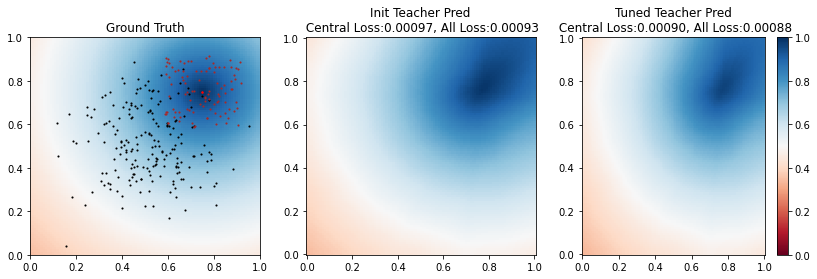

In [5]:
dotSize = 1.2
fig= plt.figure(figsize=(14,4))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
c1 = ax1.pcolormesh(x1, x2, yPlotTruth, cmap='RdBu', vmin=0, vmax=1)
ax1.scatter(xLabel[:,0].cpu().numpy(), xLabel[:,1].cpu().numpy(), c='k',s=dotSize)
ax1.scatter(xUnlabeled[:,0].cpu().numpy(), xUnlabeled[:,1].cpu().numpy(), c='brown',s=dotSize)
ax1.scatter(xObj[0].cpu().numpy(), xObj[1].cpu().numpy(), c='red', s=dotSize*2)
c2 = ax2.pcolormesh(x1, x2, yTeacherInit, cmap='RdBu', vmin=0, vmax=1)
c3 = ax3.pcolormesh(x1, x2, yTeacher, cmap='RdBu', vmin=0, vmax=1)
ax1.set_title('Ground Truth')
ax2.set_title('Init Teacher Pred\n Central Loss:%.5f, All Loss:%.5f' %(lossTeacherInit, lossAllTeacherInit))
ax3.set_title('Tuned Teacher Pred\n Central Loss:%.5f, All Loss:%.5f' %(yTestLossAfterTrain, yAllLossAfterTrain))
# set the limits of the plot to the limits of the data
ax1.axis([0, 1, 0, 1])
fig.colorbar(c1, ax=ax3)
plt.savefig('fig'+flagLabelLoc+flagUnlabelLoc+'.pdf')

In [6]:
print('Init test Loss:%.7f, after train test loss:%.7f' %(lossTeacherInit, yTestLossAfterTrain))
print('Init all Loss:%.7f, after train all loss:%.7f' %(lossAllTeacherInit, yAllLossAfterTrain))


Init test Loss:0.0009688, after train test loss:0.0008992
Init all Loss:0.0009294, after train all loss:0.0008811


In [7]:
lazy_mat = args.student.covar_module(xLabel[:5])
print(lazy_mat[0])

tensor([0.0537, 0.0274, 0.0357, 0.0383, 0.0252], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


In [8]:
args.teacher.print_weights()

torch.Size([256, 2]) torch.Size([256])
Parameter containing:
tensor([[-1.0061e-02,  3.8469e-01],
        [-5.8198e-01, -5.2039e-01],
        [-2.5592e-01,  2.0002e-01],
        [ 2.3831e-03,  5.7015e-01],
        [-6.2752e-02,  1.8711e-01],
        [-2.4678e-01,  2.4560e-02],
        [-6.6535e-01, -4.3610e-01],
        [-2.9149e-01,  2.6194e-02],
        [ 2.4337e-01,  3.8735e-01],
        [-4.7938e-01, -3.0792e-01],
        [ 2.7506e-01,  5.9925e-01],
        [-1.4552e-01,  5.2914e-01],
        [-1.1397e-01,  7.4822e-02],
        [ 8.5103e-01, -4.4876e-01],
        [-4.2186e-01, -1.6190e-01],
        [-3.0950e-01,  5.8418e-01],
        [-4.5833e-01, -3.2550e-01],
        [-4.9401e-01, -6.6225e-01],
        [-3.9013e-01,  6.2328e-01],
        [ 2.8980e-01,  3.1300e-01],
        [ 3.7188e-02, -3.6252e-01],
        [ 1.1963e-01, -6.6022e-01],
        [-5.1093e-01, -3.6453e-01],
        [ 4.5534e-01,  4.1814e-01],
        [-3.1360e-01, -2.5514e-02],
        [ 4.2279e-01,  6.6579e-01],
   

## diag:
GEV: Test Loss:0.00856, after train test loss:0.00630
Far Unlabeled data: 

    r"""
    Base class for LazyTensors in GPyTorch.

    In GPyTorch, nearly all covariance matrices for Gaussian processes are handled internally as some variety of
    LazyTensor. A LazyTensor is an object that represents a tensor object, similar to :class:`torch.tensor`, but
    typically differs in two ways:

    #. A tensor represented by a LazyTensor can typically be represented more efficiently than storing a full matrix.
       For example, a LazyTensor representing :math:`K=XX^{\top}` where :math:`K` is :math:`n \times n` but
       :math:`X` is :math:`n \times d` might store :math:`X` instead of :math:`K` directly.
    #. A LazyTensor typically defines a matmul routine that performs :math:`KM` that is more efficient than storing
       the full matrix. Using the above example, performing :math:`KM=X(X^{\top}M)` requires only :math:`O(nd)` time,
       rather than the :math:`O(n^2)` time required if we were storing :math:`K` directly.

    In order to define a new LazyTensor class that can be used as a covariance matrix in GPyTorch, a user must define
    at a minimum the following methods (in each example, :math:`K` denotes the matrix that the LazyTensor represents)

    * :func:`~gpytorch.lazy.LazyTensor._matmul`, which performs a matrix multiplication :math:`KM`
    * :func:`~gpytorch.lazy.LazyTensor._size`, which returns a :class:`torch.Size` containing the dimensions of
      :math:`K`.
    * :func:`~gpytorch.lazy.LazyTensor._transpose_nonbatch`, which returns a transposed version of the LazyTensor

    In addition to these, the following methods should be implemented for maximum efficiency

    * :func:`~gpytorch.lazy.LazyTensor._quad_form_derivative`, which computes the derivative of a quadratic form
      with the LazyTensor (e.g. :math:`d (a^T X b) / dX`).
    * :func:`~gpytorch.lazy.LazyTensor._get_indices`, which returns a :class:`torch.Tensor` containing elements that
      are given by various tensor indices.
    * :func:`~gpytorch.lazy.LazyTensor._expand_batch`, which expands the batch dimensions of LazyTensors.
    * :func:`~gpytorch.lazy.LazyTensor._check_args`, which performs error checking on the arguments supplied to the
      LazyTensor constructor.

    In addition to these, a LazyTensor *may* need to define the following functions if it does anything interesting
    with the batch dimensions (e.g. sums along them, adds additional ones, etc):
    :func:`~gpytorch.lazy.LazyTensor._unsqueeze_batch`, :func:`~gpytorch.lazy.LazyTensor._getitem`, and
    :func:`~gpytorch.lazy.LazyTensor._permute_batch`.
    See the documentation for these methods for details.

    .. note::
        The base LazyTensor class provides default implementations of many other operations in order to mimic the
        behavior of a standard tensor as closely as possible. For example, we provide default implementations of
        :func:`~gpytorch.lazy.LazyTensor.__getitem__`, :func:`~gpytorch.lazy.LazyTensor.__add__`, etc that either
        make use of other lazy tensors or exploit the functions that **must** be defined above.

        Rather than overriding the public methods, we recommend that you override the private versions associated
        with these methods (e.g. - write a custom `_getitem` verses a custom `__getitem__`). This is because the
        public methods do quite a bit of error checking and casing that doesn't need to be repeated.

    .. note::
        LazyTensors are designed by default to optionally represent batches of matrices. Thus, the size of a
        LazyTensor may be (for example) :math:`b \times n \times n`. Many of the methods are designed to efficiently
        operate on these batches if present.
    """
